# Assignment #1 – k-NN Regression
In this jupyter notebook, we will create a **standard and optimized k-NN model** for the John Hughes. 



I will evaluate the number of clusters the dataset can be successfully divided into by the **K-Means Clustering** algorithm. The `Elbow` and `Silhouette` methods will be used to determine the optimum number of clusters. Ideally, we should see that there are two main clusters in the data as there are two cancer types: `malignant` and `benign`. I will be using the cancer dataset provided in the *Introduction to Data Analysis* course to train the model.

**Lecturer: Sam Plati**<br></br>
**Module: DATA 1200 - Introduction to Data Analysis**

# Table of Contents:
* [1. Dataset Information](#dataset-information)
* [2. Loading Data](#loading-data)
* [3. Pre-Processing Data](#preprocessing-data)
* [4. Determining the Optimum Number of Clusters](#optimum-clusters)
    * [4.1 Elbow Method](#elbow-method)
    * [4.2 Silouette Method](#silhouette-method)
* [5. Creating a K-means Model](#modelling)
    * [5.1 K-means Model for Three Clusters](#modelling-2)


<a id="dataset-information"></a>
## 1. Dataset Information
The following information about the dependent and independent variables is provided by the lecturer.

**Independent Variables:**
- id: id number
- Clump Thickness: 1 - 10
- Uniformity of Cell Size: 1 - 10
- Uniformity of Cell Shape: 1 - 10
- Marginal Adhesion: 1 - 10
- Single Epithelial Cell Size: 1 - 10
- Bare Nuclei: 1 - 10
- Bland Chromatin: 1 - 10
- Normal Nucleoli: 1 - 10
- Mitoses: 1 - 10

**Dependent Variable:**
- Class: (2 for benign, 4 for malignant)

<a id="loading-data"></a>
## 2. Loading Data

In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, auc
from sklearn.neighbors import KNeighborsRegressor

from mlxtend.evaluate import bias_variance_decomp

import os
import pathlib
from pprint import pprint

In [2]:
# Define location of the data
data_dir = 'data'
filename = 'abalone.csv'
data_path = os.path.join(data_dir, filename)

if not pathlib.Path(data_path).exists():
    raise FileNotFoundError('No file found at the location defined.')

In [3]:
# Load data into a pandas DataFrame
data = pd.read_csv(data_path)
data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Overview of Dataset Characteristics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole weight    4177 non-null   float64
 4   Shucked weight  4177 non-null   float64
 5   Viscera weight  4177 non-null   float64
 6   Shell weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


In [5]:
# Check for any missing values
data.isna().sum()

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [6]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


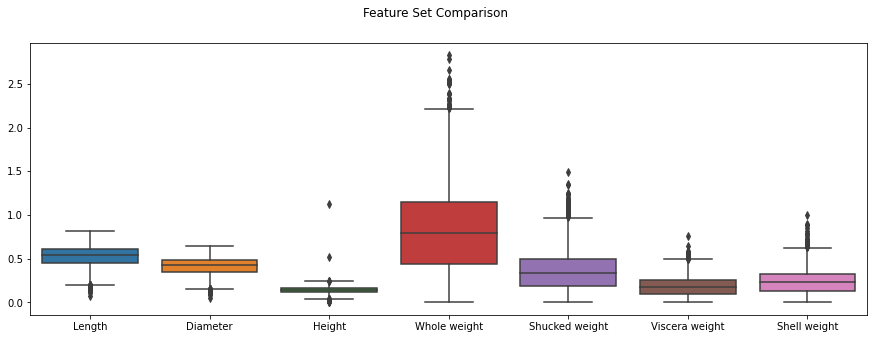

In [7]:
# BoxPlot Feature Set Comparison
fig = plt.figure(figsize=(15,5))
fig.suptitle('Feature Set Comparison')
ax = fig.add_subplot(111)
sns.boxplot(data=data.drop('Rings', axis=1))
plt.show()

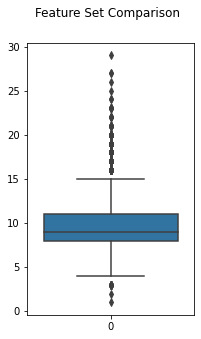

In [8]:
# BoxPlot for Rings separately due to the difference in 
fig = plt.figure(figsize=(3,5))
fig.suptitle('Feature Set Comparison')
ax = fig.add_subplot(111)
sns.boxplot(data=data['Rings'])
plt.show()

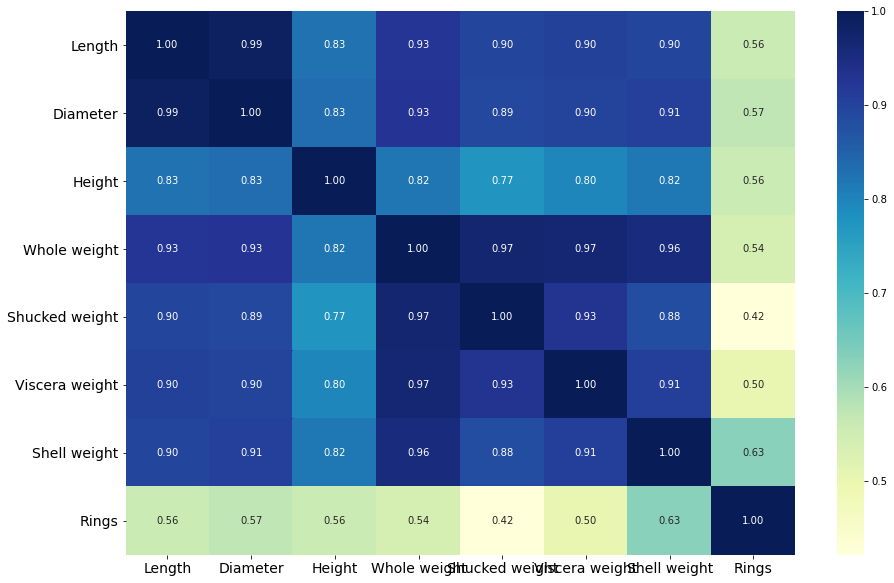

In [9]:
# Plotting the correlation matrix
df = data.copy()

# create a correlation matrix
correlation_matrix = df.corr()

# plot the matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='YlGnBu',
            ax=ax);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [10]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names

col=correlation(data,0.8)
print('Correlated columns @ 0.8:')
pprint(col, indent=3)

Correlated columns @ 0.8:
[  ('Diameter', 'Length'),
   ('Height', 'Length'),
   ('Height', 'Diameter'),
   ('Whole weight', 'Length'),
   ('Whole weight', 'Diameter'),
   ('Whole weight', 'Height'),
   ('Shucked weight', 'Length'),
   ('Shucked weight', 'Diameter'),
   ('Shucked weight', 'Whole weight'),
   ('Viscera weight', 'Length'),
   ('Viscera weight', 'Diameter'),
   ('Viscera weight', 'Whole weight'),
   ('Viscera weight', 'Shucked weight'),
   ('Shell weight', 'Length'),
   ('Shell weight', 'Diameter'),
   ('Shell weight', 'Height'),
   ('Shell weight', 'Whole weight'),
   ('Shell weight', 'Shucked weight'),
   ('Shell weight', 'Viscera weight')]


# Pre-Processing

In [11]:
# Define x and y variables for CMS prediction
x = data.drop('Rings', axis=1).to_numpy()
y = data["Rings"].to_numpy()

# Splitting data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

# Scaling the data
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

In [12]:
# Learning Curve
def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_scaled, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_root_mean_squared_error',
                                                            cv=10, random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([0,10])
    plt.show()

k-NN Regressor Learning Curve


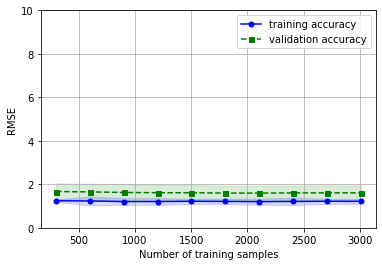

In [13]:
# Plot Learning Curve
print('k-NN Regressor Learning Curve')
plot_learning_curves(KNeighborsRegressor(2))

In [14]:
#Script for Bias Variance
print('Bias Variance Trade-Off')
for name,method in[('kNN',KNeighborsRegressor(2))]:        
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        method, x_train_scaled, y_train, x_test_scaled, y_test, 
        loss='mse',
        random_seed=100)
    print('\nEstimator: {}'.format(name)) 
    print('Average Bias: {:.2f}'.format(avg_bias))
    print('Average Variance: {:.2f}'.format(avg_var))  

Bias Variance Trade-Off

Estimator: kNN
Average Bias: 5.69
Average Variance: 1.64


In [15]:
#Original Model - KNN

#Search for an optimal value of K for KNN
from sklearn.model_selection import cross_val_score
from sklearn import metrics  

k_range = range(1, 10)
k_scores = []

for k in k_range:
    knn_org = KNeighborsRegressor(n_neighbors=k)
    #obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn_org, x_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error')
    #append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
    
#Print Best Score
BestScore = [1 - x for x in k_scores]
best_k = k_range[BestScore.index(min(BestScore))]

#Create Orginal KNN model
classifier_org = KNeighborsRegressor(n_neighbors = best_k)

#Fit KNN Model
classifier_org.fit(x_train_scaled, y_train)

#Prediction
y_pred_org = classifier_org.predict(x_test_scaled)

print('Original Model')
print('\nn_neighbors:',str(best_k))
print('\nR2: {:.2f}'.format(metrics.r2_score(y_test, y_pred_org)))
adjusted_r_squared = 1-(1-metrics.r2_score(y_test,y_pred_org))*(len(y)-1)/(len(y)-x.shape[1]-1)
print('Adj_R2: {:0.2f}'.format(adjusted_r_squared))
print('Mean Absolute Error: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_pred_org)))  
print('Mean Squared Error: {:0.2f}'.format(metrics.mean_squared_error(y_test, y_pred_org)))  
print('Root Mean Squared Error: {:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_org))))  

Original Model

n_neighbors: 9

R2: 0.51
Adj_R2: 0.51
Mean Absolute Error: 1.57
Mean Squared Error: 5.03
Root Mean Squared Error: 2.24


In [24]:
#Gridsearch
from sklearn.model_selection import GridSearchCV

#k-NN Regression Model
knnreg2 = KNeighborsRegressor()
k_range = range(1, 20)
param_grid = { 
           'n_neighbors': k_range,
           'algorithm' : ['auto','ball_tree','kd_tree','brute'],
           'weights' : ['uniform','distance']}

knn_model = GridSearchCV(knnreg2, param_grid, cv=10, verbose=1,
                         scoring='neg_root_mean_squared_error')

grids = [knn_model] 
grid_dict = {0:'k-NN Regression Model'}

#Model Creation

#Create Heading
print('Optimized Model') 

#Fit the grid search objects 
for idx, optmodel in enumerate(grids): 
     print('\nEstimator: {}'.format(grid_dict[idx])) 
     #Fit grid search
     optmodel.fit(x_train_scaled, y_train) 
     #Best params 
     print('\nBest params: {}'.format(optmodel.best_params_)) 
     # Predict on test data with best params 
     y_pred3 = optmodel.predict(x_test_scaled) 
     # Test data accuracy of model with best params    
     print('\nR2: {:.2f}'.format(metrics.r2_score(y_test, y_pred3)))
     adjusted_r_squared = 1-(1-metrics.r2_score(y_test,y_pred3))*(len(y)-1)/(len(y)-x.shape[1]-1)
     print('Adj_R2: {:0.2f}'.format(adjusted_r_squared))  
     #Print MSE and RMSE
     print('Mean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred3)))
     print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred3)))
     print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred3))))  

Optimized Model

Estimator: k-NN Regression Model
Fitting 10 folds for each of 152 candidates, totalling 1520 fits

Best params: {'algorithm': 'auto', 'n_neighbors': 17, 'weights': 'distance'}

R2: 0.54
Adj_R2: 0.53
Mean Absolute Error: 1.52
Mean Squared Error: 4.81
Root Mean Squared Error: 2.19
